# **LING572 Final Project**

## Alabama Census Data Project #2

The purpose of this notebook is to compare income levels for a variety of levels of education for whites and non-whites in Alabama.

The data used for this analysis is provided by the U.S. Census 2000 PUMS (Public Use Microdata Samples) dataset.

This notebook was created in Google Colab, so all of the data and scripts were previously saved onto my own Google Drive for importing. A link to the ZIP file is provided below:

https://gawron.sdsu.edu/python_for_ss/course_core/book_draft/_static/pums_example.zip

# Importing and Declaration

To start off, we need to import the necessary packages in order to save our data through Google Drive. After importing, we can use the data we gathered from each path to declare it to a variable of our choice, which we can use for data analysis.

In [ ]:
import importlib.util
import os.path
from google.colab import drive

drive.mount('/content/gdrive')
code_dir = '/content/gdrive/My Drive/census/'

filename = os.path.join(code_dir, 'read_in_census_data.py')
spec = importlib.util.spec_from_file_location('census', filename)

census = importlib.util.module_from_spec(spec)
spec.loader.exec_module(census)
data_dir = code_dir
one_percent_data_file = os.path.join(data_dir, 'revisedpums1_alabama_01.txt')

data_dictionary = os.path.join(data_dir, '5%_PUMS_record_layout.xls')

ci = census.CensusInfo(data_dictionary)
df = census.DataFrameWrapper(ci)

Mounted at /content/gdrive
Processing 'Housing Unit Record' Sheet

Processing 'Person Record' Sheet



# Census Information

We have now declared **ci**, the Census information, and **df**, the DataFrame that holds the data we need. Now, we can look into the Census information and narrow down the data to what we desire.

In this case, the only data we need is **Education Level**, **Race**, and **Income Level**.

In [ ]:
ci.print_var_info('EDUC', ci.person_record)
ci.print_var_info('race', ci.person_record)
ci.print_var_info ('income', ci.person_record)

Person Record EDUC 1% file {'RT': 'P', 'BEG': 53, 'LEN': 2, 'DESCRIPTION': 'Educational Attainment'}

     Educational Attainment
     00  Not in universe (Under 3 years)
     01  No schooling completed
     02  Nursery school to 4th grade
     03  5th grade or 6th grade
     04  7th grade or 8th grade
     05  9th grade
     06  10th grade
     07  11th grade
     08  12th grade, no diploma
     09  High school graduate
     10  Some college, but less than 1 year
     11  One or more years of college, no degree
     12  Associate degree
     13  Bachelor's degree
     14  Master's degree
     15  Professional degree
     16  Doctorate degree

Person Record race => RACE3 1% file {'RT': 'P', 'BEG': 41, 'LEN': 2, 'DESCRIPTION': 'Race Recode 3'}

     Race Recode 3
     01  Some other race alone
     02  Other Pacific Islander alone
     03  Other Pacific Islander; Some other race
     04  Samoan alone
     05  Guamanian or Chamorro alone
     06  Native Hawaiian alone
     07  Other Asia

# DataFrame

From the output above, we can derive that:

*   Education Level can be separated by number
*   From the race recode, "47" is declared as "white alone", which means "non-white" is every other number besides "47"
* Income Level is by USD

With this information in mind, we can continue on to working with the DataFrame and filtering the data in order to compare incomes levels by education.



In [ ]:
df.header

['serial_no', 'race', 'education', 'income', 'gender', 'age', 'relationship']

In [ ]:
df.save_frame('alabama_pums_extract.csv', header=True)

In [ ]:
import pandas as pd
import numpy as np

dt_dict = {'serial_no':object, 'race':object, 'gender':object, 'relationship':object}
p_df = pd.read_csv('alabama_pums_extract.csv', dtype=dt_dict)

In [ ]:
p_df.to_csv('alabama_pums_extract3.csv', index=False)

In [ ]:
p_df

,serial_no,race,education,income,gender,age,relationship
0,0000117,47,12,47300.0,1,31,01
1,0000117,47,12,24300.0,2,25,02
2,0000117,47,0,NaN,1,0,03
3,0000127,47,5,0.0,1,22,01
4,0000127,47,10,22000.0,2,35,02
...,...,...,...,...,...,...,...
44482,0999820,37,1,NaN,1,5,08
44483,0999820,37,7,0.0,1,42,13
44484,0999826,37,8,0.0,2,29,01
44485,0999826,37,5,NaN,1,14,03


Here we have a readable table of the data. However, some columns will be unecessary for this task. So we will need to isolate the race, education, and income columns and make bins for graphing.

First, it would be ideal to add an indicator of which rows are "white" or "non-white."

In [ ]:
p_df['white_only'] = p_df['race'].map(lambda x: x == '47')

In [ ]:
p_df

,serial_no,race,education,income,gender,age,relationship,white_only
0,0000117,47,12,47300.0,1,31,01,True
1,0000117,47,12,24300.0,2,25,02,True
2,0000117,47,0,NaN,1,0,03,True
3,0000127,47,5,0.0,1,22,01,True
4,0000127,47,10,22000.0,2,35,02,True
...,...,...,...,...,...,...,...,...
44482,0999820,37,1,NaN,1,5,08,False
44483,0999820,37,7,0.0,1,42,13,False
44484,0999826,37,8,0.0,2,29,01,False
44485,0999826,37,5,NaN,1,14,03,False


# Filtering Data

Now that we have added a "white-only" column containing boolean values indicating whether the row is white, or has a race code of 47, we can narrow down our DataFrame.

It would also help if the education level was shown by the name of the degree obtained instead of its code number.

The following declaration will be used:

AA = Associate Degree = 12

BA = Bachelor's Degree = 13

HD = Professional/Doctorate Degree = 15+

HS = High School Degree = 9-11

MA = Master's Degree = 14

ND = No Degree = 8 or less

This information was taken from the Census information we gathered earlier about Education Levels. Now, we can make the following function:

In [ ]:
def education (x):
    
    if 9 <= x <= 11:
        return 'HS'
    elif x == 12:
        return 'AA'
    elif x == 13:
        return 'BA'
    elif x == 14:
        return 'MA'
    elif x > 14:
        return 'HD'
    else:
        return 'ND'
p_df_inc = p_df[p_df['income']>0]
p_df_inc['degrees'] = p_df_inc['education'].map(education)
p_df_inc['white_only'] = p_df['race'].map(lambda x: x == '47')
p_df_inc2 = p_df_inc.loc[:,['degrees','income','white_only']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
p_df_inc2

,degrees,income,white_only
0,AA,47300.0,True
1,AA,24300.0,True
4,HS,22000.0,True
6,ND,5000.0,True
7,BA,13000.0,True
...,...,...,...
44473,ND,500.0,True
44476,HS,2000.0,False
44477,HS,12000.0,False
44480,HS,30000.0,True


The table above shows all data from the original DataFrame that is legitimate and useful, meaning that the income is more than 0, the degrees show as their abbreviated names, and the "white-only" column still reveals who is white or not.

We have all of the necessary information to separate the data into two parts: white and non-white.

In [ ]:
white = p_df_inc2[p_df_inc2['white_only'] == True]
nonwhite = p_df_inc2[p_df_inc2['white_only'] == False]

In [ ]:
white

,degrees,income,white_only
0,AA,47300.0,True
1,AA,24300.0,True
4,HS,22000.0,True
6,ND,5000.0,True
7,BA,13000.0,True
...,...,...,...
44467,HS,15900.0,True
44469,ND,12000.0,True
44470,ND,1400.0,True
44473,ND,500.0,True


In [ ]:
nonwhite

,degrees,income,white_only
11,MA,32000.0,False
18,BA,24000.0,False
28,HS,750.0,False
46,ND,1200.0,False
47,BA,30000.0,False
...,...,...,...
44457,BA,14000.0,False
44459,HS,33000.0,False
44476,HS,2000.0,False
44477,HS,12000.0,False


In [ ]:
whitegroup = white.groupby(['degrees']).mean()
whitegroup

,income,white_only
degrees,,
AA,30578.720238,True
BA,44145.258260,True
HD,90588.130841,True
HS,24749.638879,True
MA,45636.859122,True
ND,18170.306513,True


In [ ]:
nonwhitegroup = nonwhite.groupby(['degrees']).mean()
nonwhitegroup

,income,white_only
degrees,,
AA,25227.164634,False
BA,31958.826185,False
HD,54027.586207,False
HS,18767.240446,False
MA,36457.185629,False
ND,14793.487461,False


By using aggregation, the mean income in both tables is grouped by degree obtained. This will be sufficient information to graph a bar chart of each group.

# Graphing & Conclusion

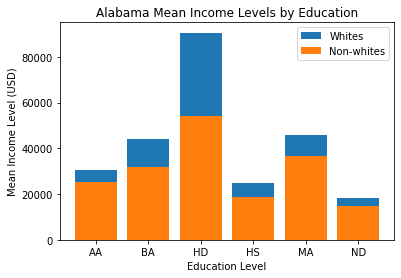

In [ ]:
import matplotlib.pyplot as plt

labels = ['AA', 'BA', 'HD', 'HS', 'MA', 'ND']
values = list(whitegroup['income'].values)
values1 = list(nonwhitegroup['income'].values)

plt.title('Alabama Mean Income Levels by Education')

plt.bar(labels, values, label='Whites')
plt.bar(labels, values1, label='Non-whites')

plt.xlabel('Education Level')
plt.ylabel('Mean Income Level (USD)')

plt.legend()

plt.show()

Based on the bar chart above, we can conclude that:

* Whites on average have a higher income level than non-whites, no matter the education level
* Whites with a Professional/Doctorate degree have the highest income level overall
* Non-whites with no degree have the lowest income level overall
* Whites and non-whites with a Professional/Doctorate degree have the largest gap in income level
* Whites and non-whites with no degree have the smallest gap in income level
* Whites may receive more opportunities than non-whites based on education alone
* As education level rises, the level of income rises with it